In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import string, re, emoji
import itertools
from collections import Counter

# Libraries for text preprocessing.

import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud,STOPWORDS
# Text Preprocessing
import morfeusz2

# Loading some sklearn packaces
from sklearn.feature_extraction.text import CountVectorizer

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
import morfeusz2
import pl_core_news_md

from scipy.stats import kstest

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches


stop = set(stopwords.words('polish'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


In [2]:
nlp = pl_core_news_md.load()

In [3]:
DATAPATH = r'Tweety25k-1.xlsx'
STOPWORDS = r'E:\coding\pythonnew\POLHATE-project\data\raw\polish_stopwords.txt'

In [4]:
df = pd.read_excel(DATAPATH)

df = pd.concat([df[df['label'] == 1], df[df['label'] == 0]])
df.shape


(20928, 3)

In [5]:
df = pd.read_excel(DATAPATH)
# df = pd.read_csv(DATAPATH)
df = pd.concat([df[df['label'] == "1"], df[df['label'] == "0"]])
df.label = df.label.astype(int)
df.head()

Empty DataFrame
Columns: [id, text, label]
Index: []

# Helper functions to clean text by removing urls, emojis, html tags and punctuations.

In [6]:
morf = morfeusz2.Morfeusz()

def lowercase(text: str) -> str:
    """Converts letters in given text to lowercase.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Lowercase text.

    """
    return str.lower(str(text))

def remove_hashtags(text: str) -> str:
    """Removes hashtags from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no hashtags.

    """
    preprocessedText = re.sub('#[a-zA-Z0-9_]+', '', text )

    return preprocessedText

def remove_mentions(text: str) -> str:
    """Removes mentions from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no mentions.

    """
    preprocessedText = re.sub('@[a-zA-Z0-9_]+', '', text )

    return preprocessedText

def remove_punctuation(text: str) -> str:
    """Removes non text characters from given tweet text.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no non tex characters.

    """
    preprocessedText = text.translate(str.maketrans('', '', string.punctuation))

    return preprocessedText

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def lemmatize(text: str) -> str:
    """Lemmatizes polish text from given tweet.
    Args:
        text (str): Text to preprocess.
    Returns:
        lemmatizedText (str): Lemmatized text.

    """
    wordList = text.split()
    lemmatizedWordList = []

    for word in wordList:    
        _, _, interpretation = morf.analyse(word)[0]
        lemWord = interpretation[1]
        lemWordStripped = lemWord.split(':', 1)[0].lower()
        lemmatizedWordList.append(lemWordStripped)

    lemmatizedText = ' '.join(lemmatizedWordList)

    return lemmatizedText

def remove_html(text):
    """_summary_

    Args:
        text (_type_): _description_

    Returns:
        _type_: _description_
    """
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_stopwords(text: str) -> str:
    """Removes stopwords.
    Args:
        text (str): Text to preprocess.
    Returns:
        preprocessedText (str): Text with no stopwords.

    """
    wordList = text.split() 
    preprecessedWordList = []

    stopWords = stopwords.words('polish')
    # stopWords += ['rt']

    for word in wordList:
        if word not in stopWords:
            preprecessedWordList.append(word)

    preprocessedText = ' '.join(preprecessedWordList)

    return preprocessedText


# DATA PREPROCESSING

In [7]:
# Remove blank rows if any.
df['text'].dropna(inplace=True)

# Applying helper functions

df['text_clean'] = df['text'].apply(lambda x: lowercase(x))
print(df['text_clean'].shape)
df['text_clean'] = df['text_clean'].apply(lambda x: remove_hashtags(x))
print(df['text_clean'].shape)
df['text_clean'] = df['text_clean'].apply(lambda x: remove_mentions(x))
print(df['text_clean'].shape)
df['text_clean'] = df['text_clean'].apply(lambda x: remove_emoji(x))
print(df['text_clean'].shape)
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
print(df['text_clean'].shape)
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punctuation(x))
print(df['text_clean'].shape)
df['text_clean'] = df['text_clean'].apply(lambda x: lemmatize(x))
print(df['text_clean'].shape)
df['text_clean'] = df['text_clean'].apply(lambda x: remove_stopwords(x))
print(df['text_clean'].shape)
df['tokenized'] = [word_tokenize(entry) for entry in df['text_clean']]
print(df['text_clean'].shape)
df['tokenized_count'] = df['tokenized'].apply(lambda x: len(x))
print(df['text_clean'].shape)
df['text_clean']= [str(word_tokenize(entry)) for entry in df['text_clean']]

df['text_str'] = df['text_clean'].apply(lambda x: ' '.join(eval(x)))

(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


In [8]:
df[df.tokenized_count == 4].shape

(0, 7)

In [9]:
.shape

SyntaxError: invalid syntax (1189770672.py, line 1)

In [ ]:
df = df[df.tokenized_count > 3]

# Exploratory data analysis

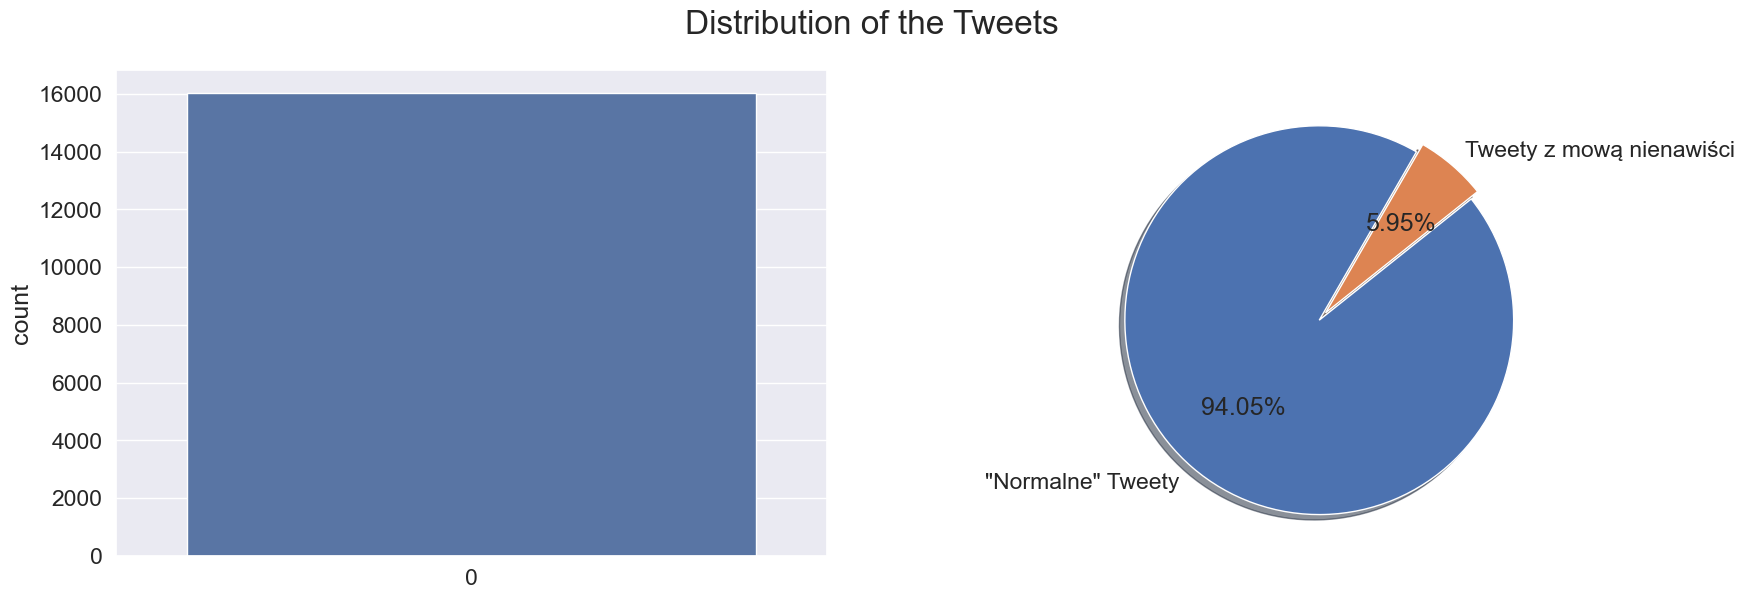

In [ ]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(df['label'], ax=axes[0])
axes[1].pie(df['label'].value_counts(),
            labels=['"Normalne" Tweety', 'Tweety z mową nienawiści'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [ ]:
# Creating a new feature for the visualization.

df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

In [ ]:
df.label.value_counts()

label
0    15077
1      954
Name: count, dtype: int64

In [ ]:
df[df.label==1].iloc[2]

id                                               1634274490908590080
text               @Dariusz_Jonski @SasinJacek @piotr_borys @Jaro...
label                                                              1
text_clean         ['szmat', 'kurwa', 'atakować', 'jana', 'paweł'...
tokenized          [szmat, kurwa, atakować, jana, paweł, ii, szma...
tokenized_count                                                   12
text_str           szmat kurwa atakować jana paweł ii szmat zrobi...
Name: 20, dtype: object

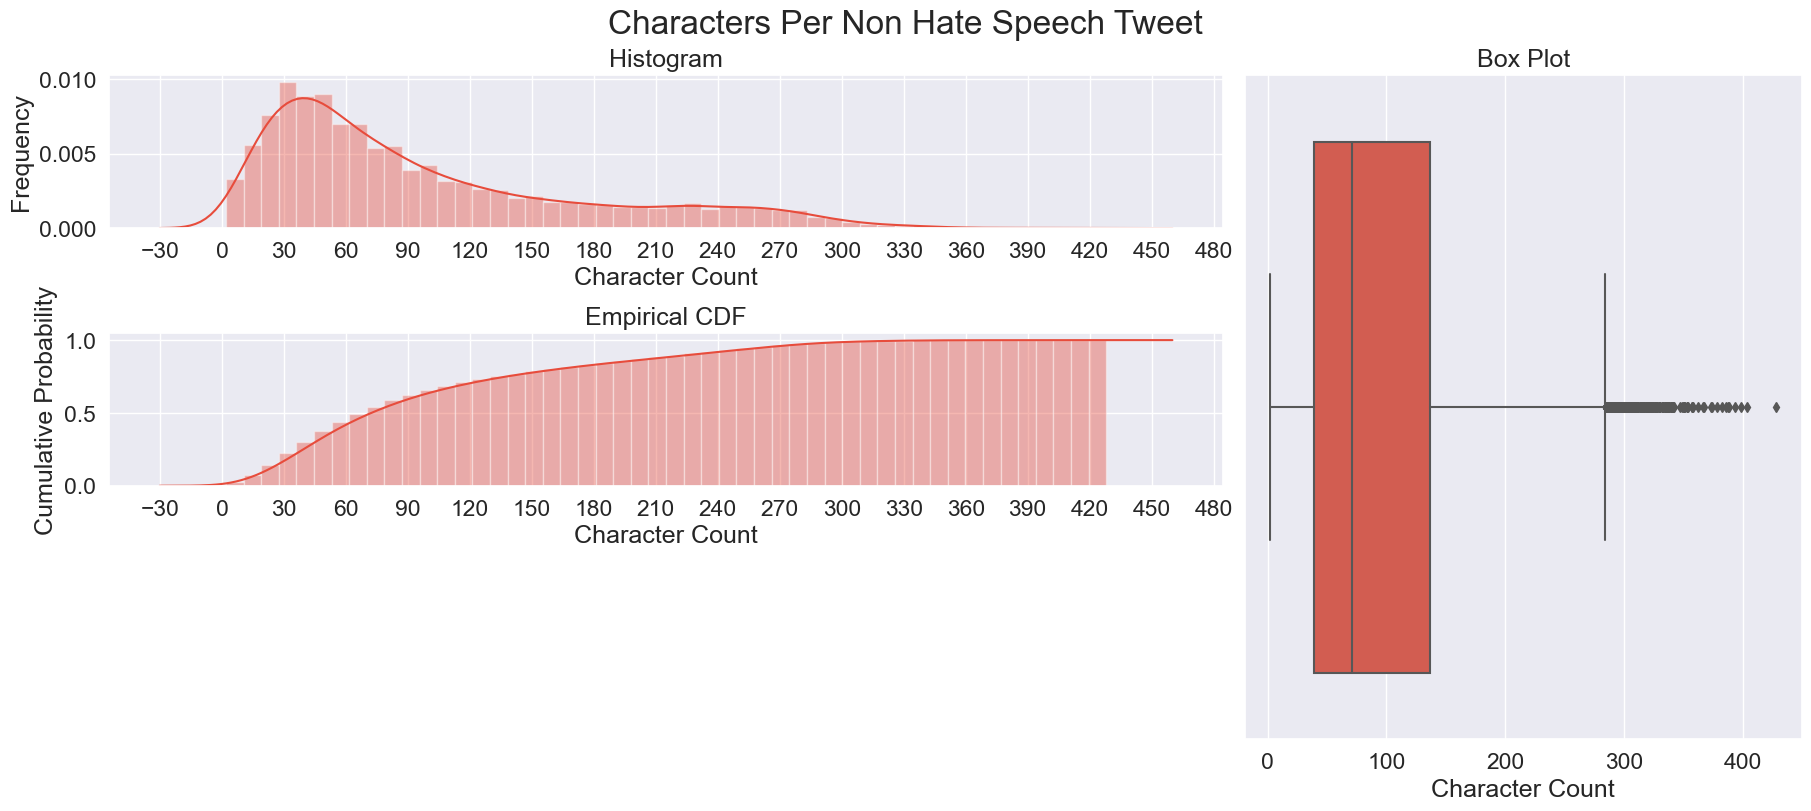

In [ ]:
plot_dist3(df[df['label'] == 0], 'Character Count',
           'Characters Per Non Hate Speech Tweet')

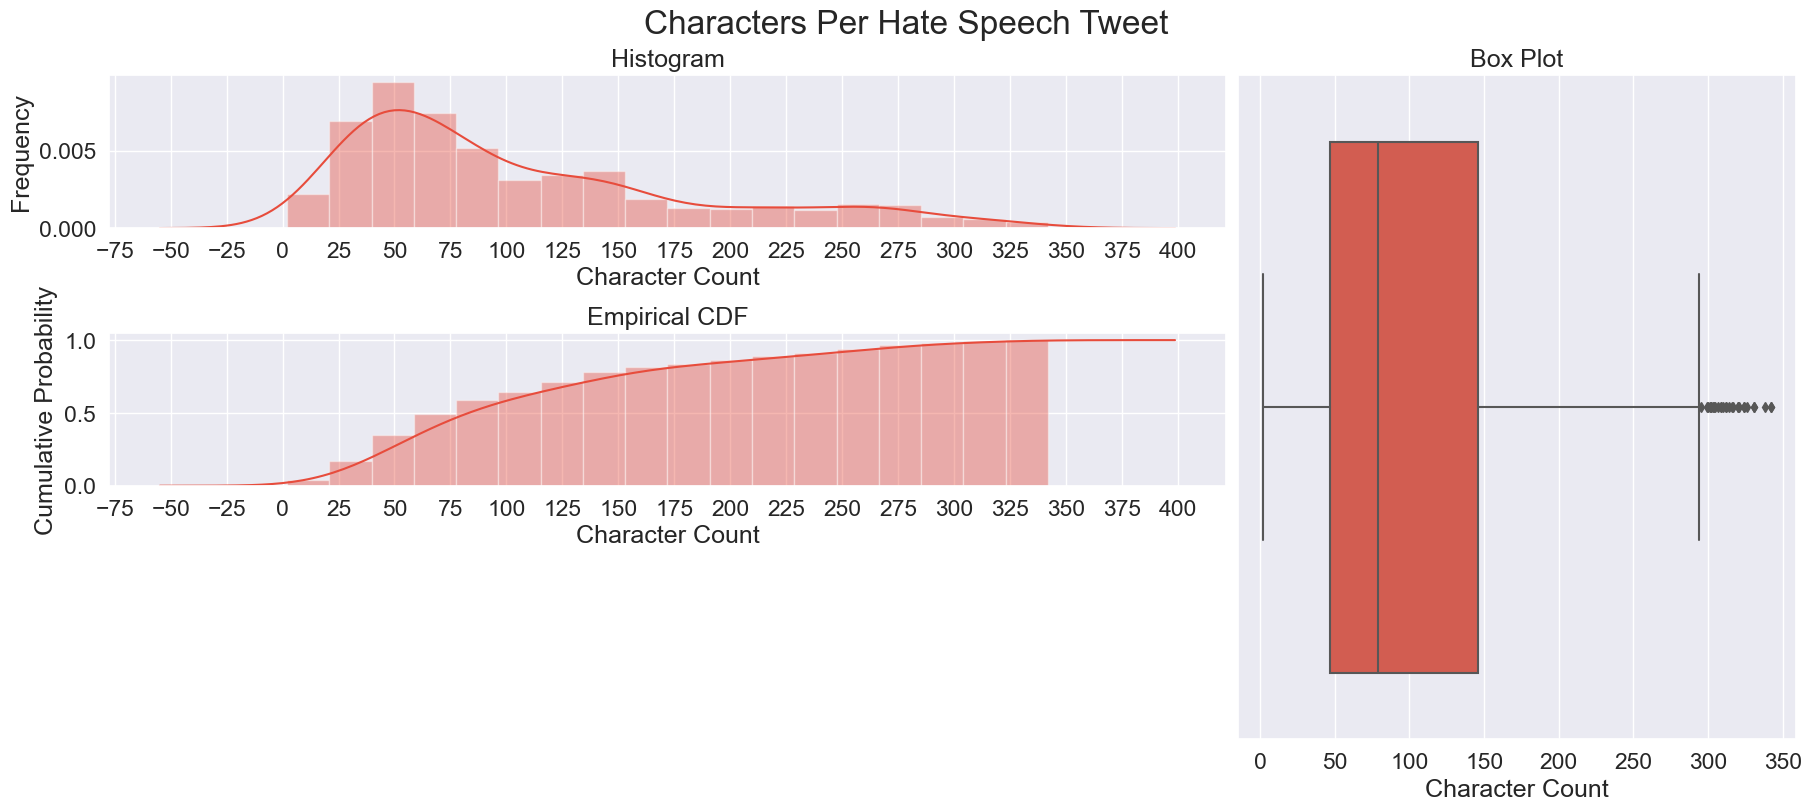

In [ ]:
plot_dist3(df[df['label'] == 1], 'Character Count',
           'Characters Per Hate Speech Tweet')

In [ ]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Liczba słów w komentarzu')
    axes[0].set_ylabel('Częstość występowania')
    axes[0].set_title('Tweety "normalne"')
    axes[1].set_xlabel('Liczba słów w komentarzu')
    axes[1].set_title('Tweety z mową nienawiści')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

In [ ]:
df[df['label'] == 0].word_count.mean()

11.240299794388804

In [ ]:
df[df['label'] == 1].word_count.mean()

11.224318658280922

In [ ]:
df.text = df.text.astype(str)

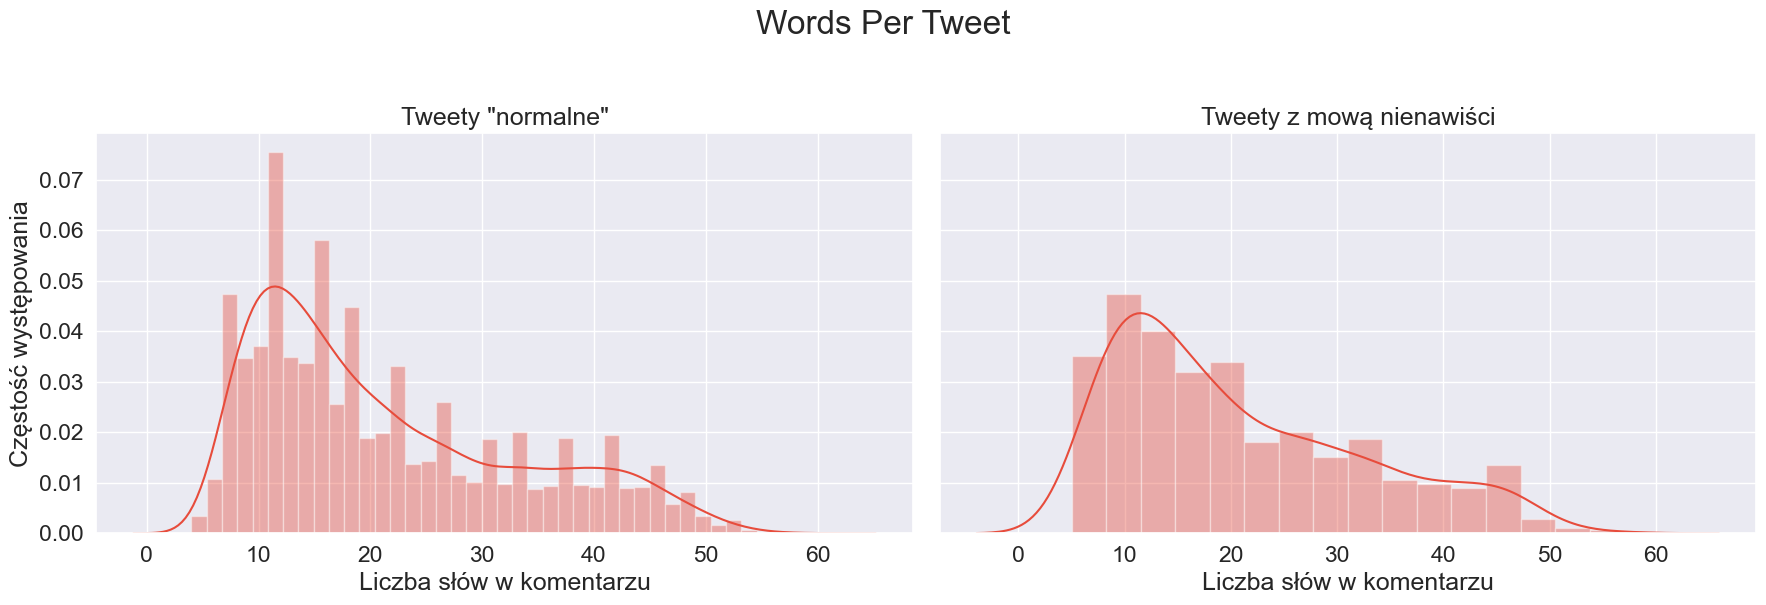

In [ ]:
plot_word_number_histogram(df[df['label'] == 0]['text'],
                           df[df['label'] == 1]['text'])

In [ ]:
def plot_word_len_histogram(textno, textye):
    
    """A function for comparing average word length"""
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='#e74c3c')
    
    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Hate Speech Tweets')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Hate Speech Tweets')
    
    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()

## Check for stopwords left in dataset

In [ ]:
lis = [
    df[df['label'] == 0]['text_str'],
    df[df['label'] == 1]['text_str']
]

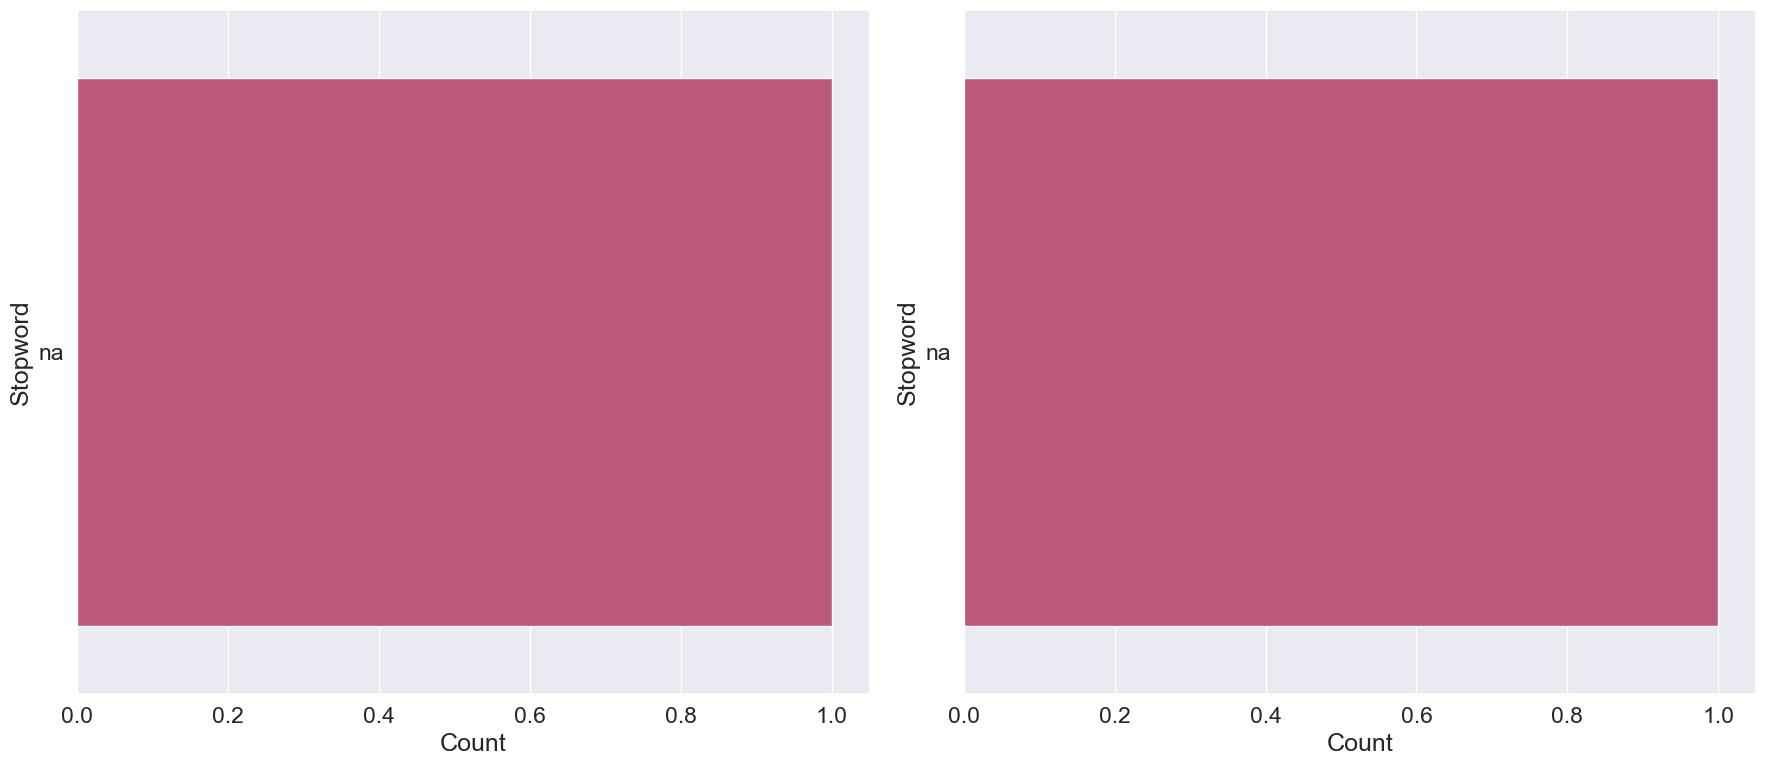

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        x, y = zip(*top)
        df1 = pd.DataFrame([x, y]).T
        df1 = df1.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df1, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

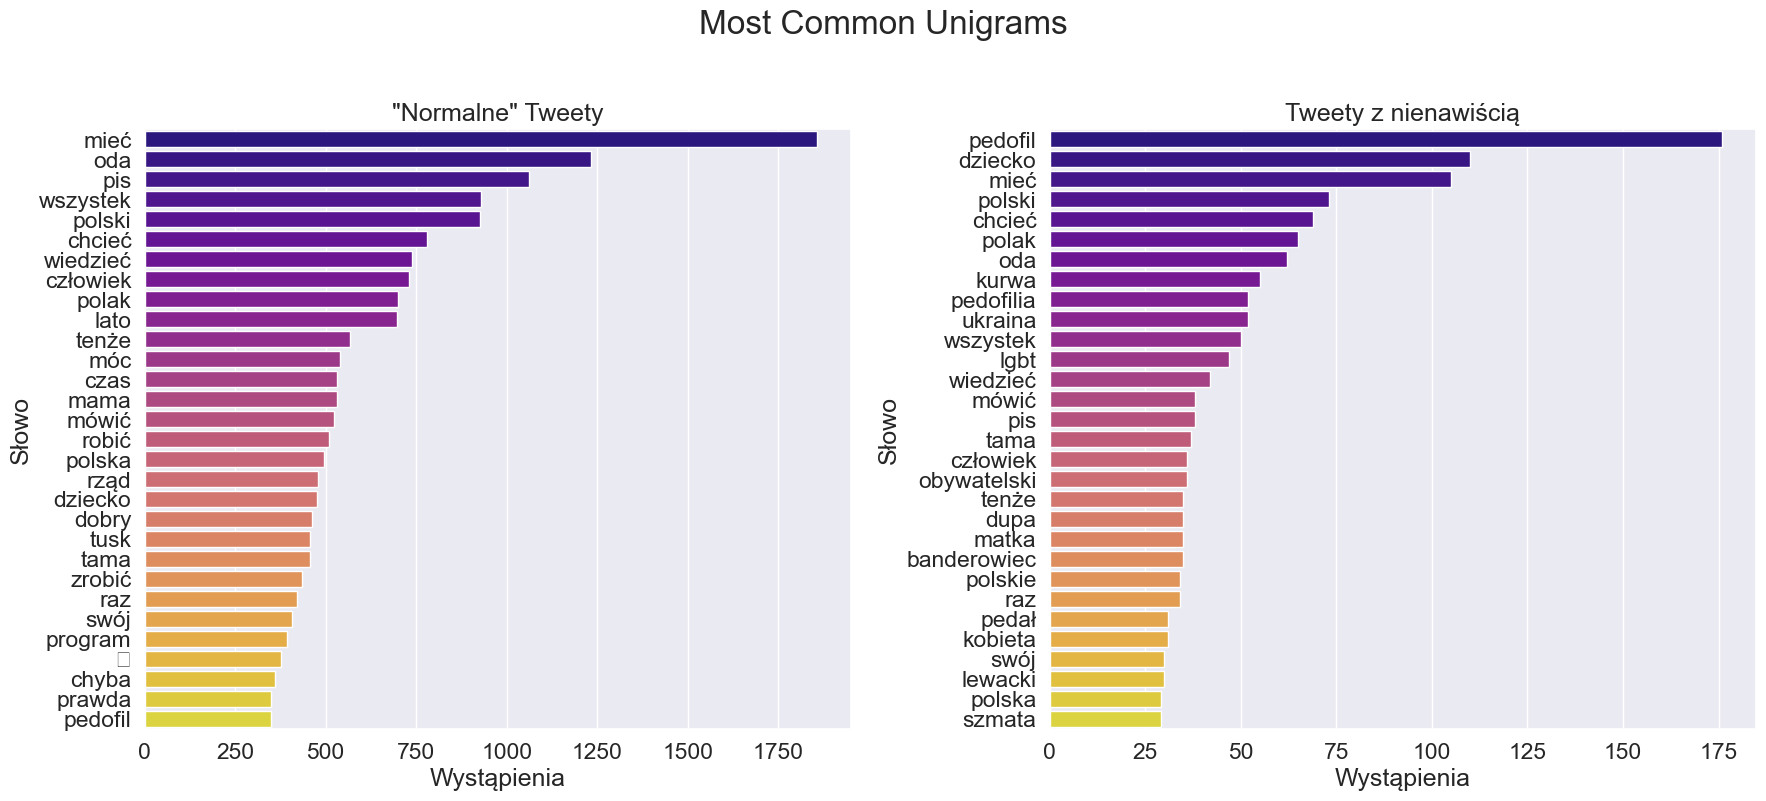

In [ ]:
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('"Normalne" Tweety')

axes[1].set_title('Tweety z nienawiścią')
axes[0].set_xlabel('Wystąpienia')
axes[0].set_ylabel('Słowo')
axes[1].set_xlabel('Wystąpienia')
axes[1].set_ylabel('Słowo')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [ ]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('"Normalne" Tweety')

        axes[1].set_title('Tweety z nienawiścią')
        axes[0].set_xlabel('Wystąpienia')
        axes[0].set_ylabel('Słowo')
        axes[1].set_xlabel('Wystąpienia')
        axes[1].set_ylabel('Słowo')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

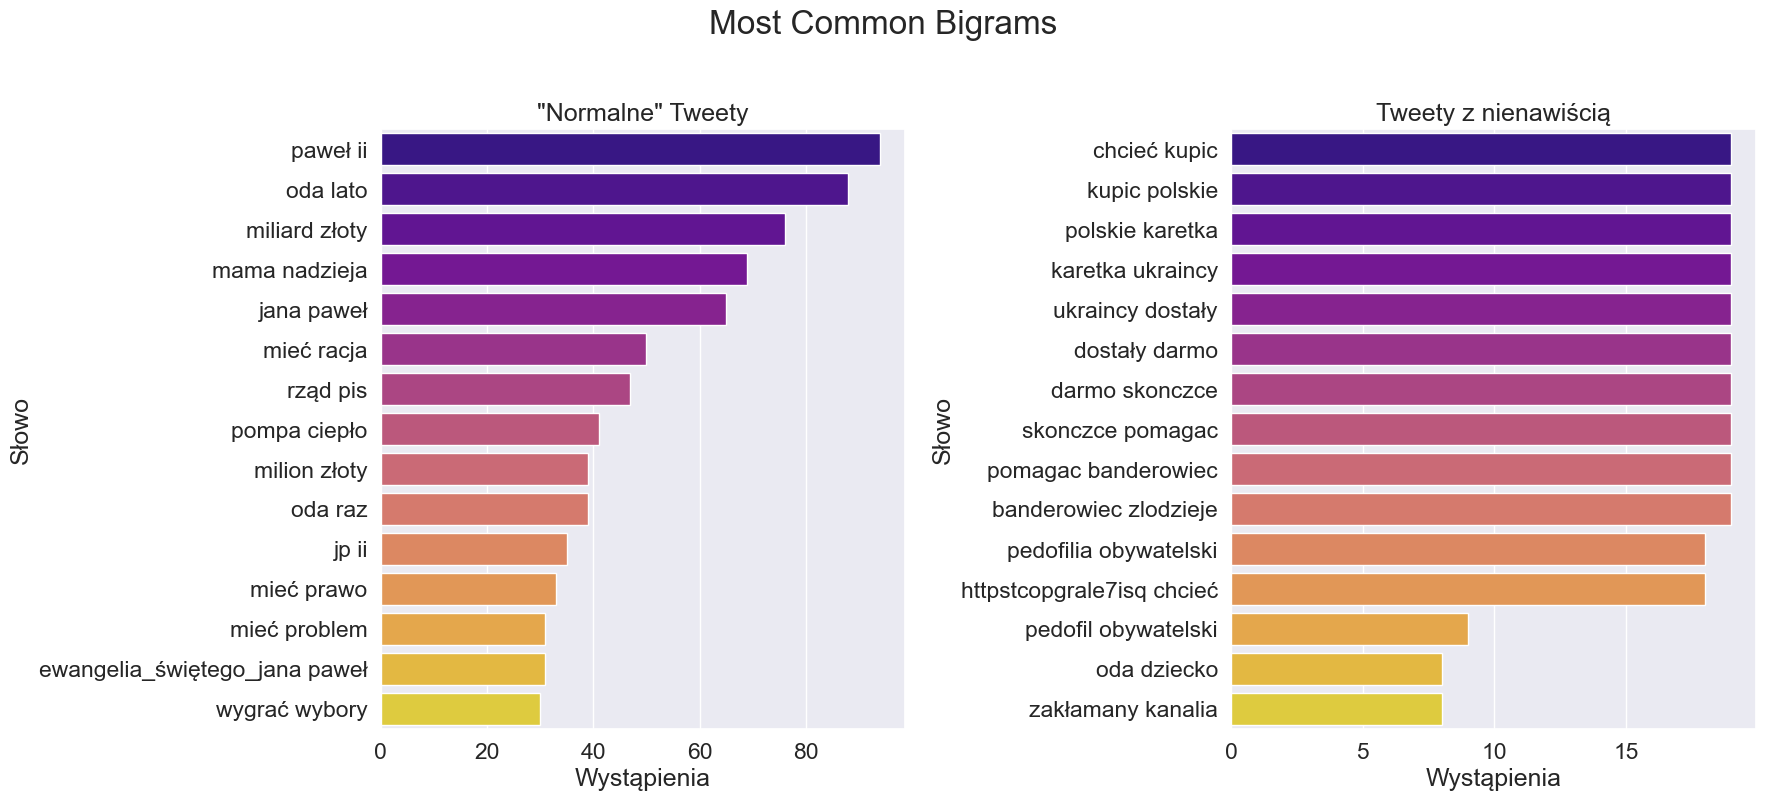

In [ ]:
ngrams(2, 'Most Common Bigrams')

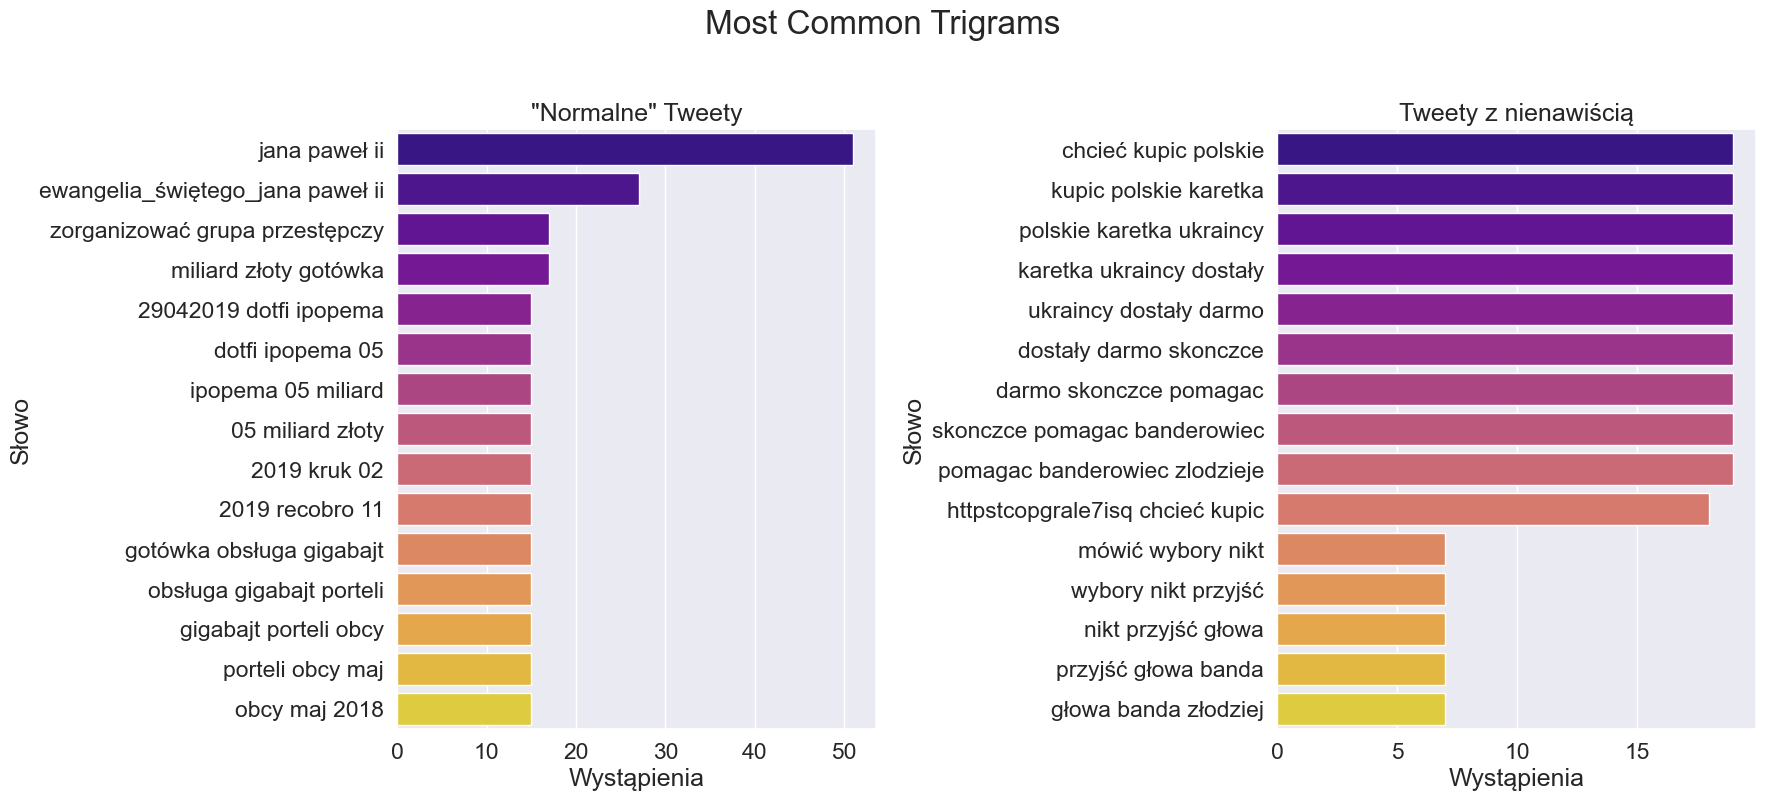

In [ ]:
ngrams(3, 'Most Common Trigrams')

In [ ]:
df.head()

id                                               text  \
6   1634443414627405825  @Dariusz_Jonski @SasinJacek @piotr_borys @Jaro...   
14  1634382963402997760  @Dariusz_Jonski @SasinJacek @piotr_borys @Jaro...   
16  1634285394798825497  @Dariusz_Jonski @SasinJacek @piotr_borys @Jaro...   
18  1634281895675547667  @Dariusz_Jonski @SasinJacek @piotr_borys @Jaro...   
20  1634274490908590080  @Dariusz_Jonski @SasinJacek @piotr_borys @Jaro...   

    label                                         text_clean  \
6       1  ['wytłumaczyć', 'polak', 'szereg', 'pedofil', ...   
14      1               ['wypierdalać', 'scyrby', 'peofilu']   
16      1                                 ['drugi', 'pedał']   
18      1    ['pedofilski', 'partia', 'oplowac', 'faszysci']   
20      1  ['szmat', 'kurwa', 'atakować', 'jana', 'paweł'...   

                                            tokenized  tokenized_count  \
6   [wytłumaczyć, polak, szereg, pedofil, człowiek...               15   
14                     [wypierdalać, scyrby, peofilu]                3   
16                                     [drugi, pedał]                2   
18            [pedofilski, partia, oplowac, faszysci]                4   
20  [szmat, kurwa, atakować, jana, paweł, ii, szma...               12   

                                             text_str  Character Count  
6   wytłumaczyć polak szereg pedofil człowiek siła...              163  
14                         wypierdalać scyrby peofilu               36  
16                                        drugi pedał               18  
18                 pedofilski partia oplowac faszysci               47  
20  szmat kurwa atakować jana paweł ii szmat zrobi...              118

(-0.5, 1599.5, 799.5, -0.5)

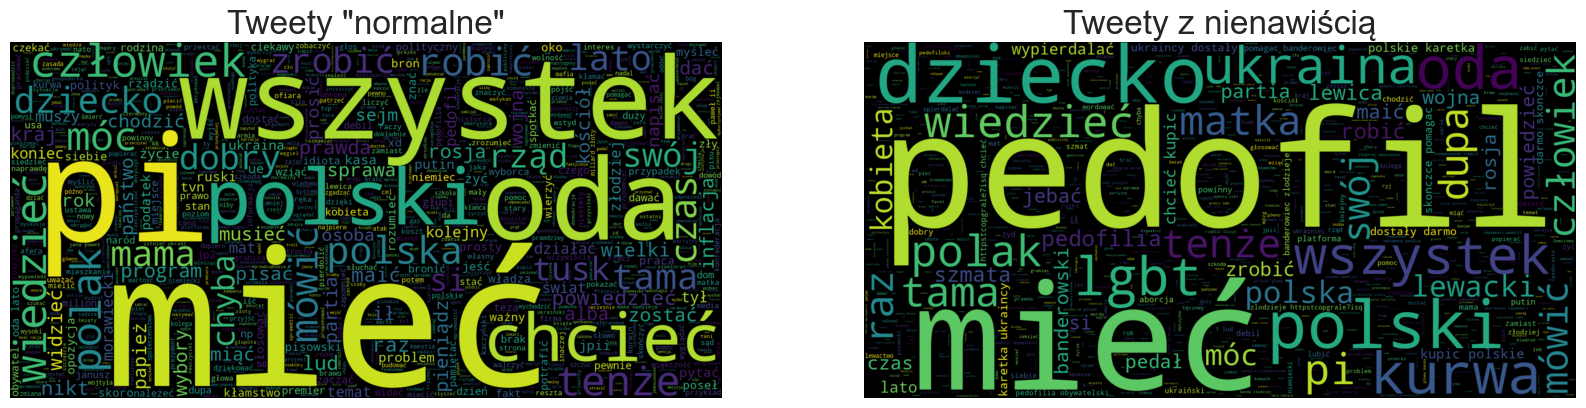

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

wc0 = WordCloud(
    max_words = 1000,
    width = 1600,
    height = 800,
    stopwords = STOPWORDS
    ).generate(" ".join(df[df.label == 0].text_str))
wc1 = WordCloud(
    max_words = 1000,
    width = 1600,
    height = 800,
    stopwords = STOPWORDS
    ).generate(" ".join(df[df.label == 1].text_str))



ax[0].imshow(wc0, interpolation='bilinear')
ax[0].set_title('Tweety "normalne"', fontsize=24)
ax[0].axis('off')
ax[1].imshow(wc1, interpolation='bilinear')
ax[1].set_title('Tweety z nienawiścią', fontsize=24)
ax[1].axis('off')

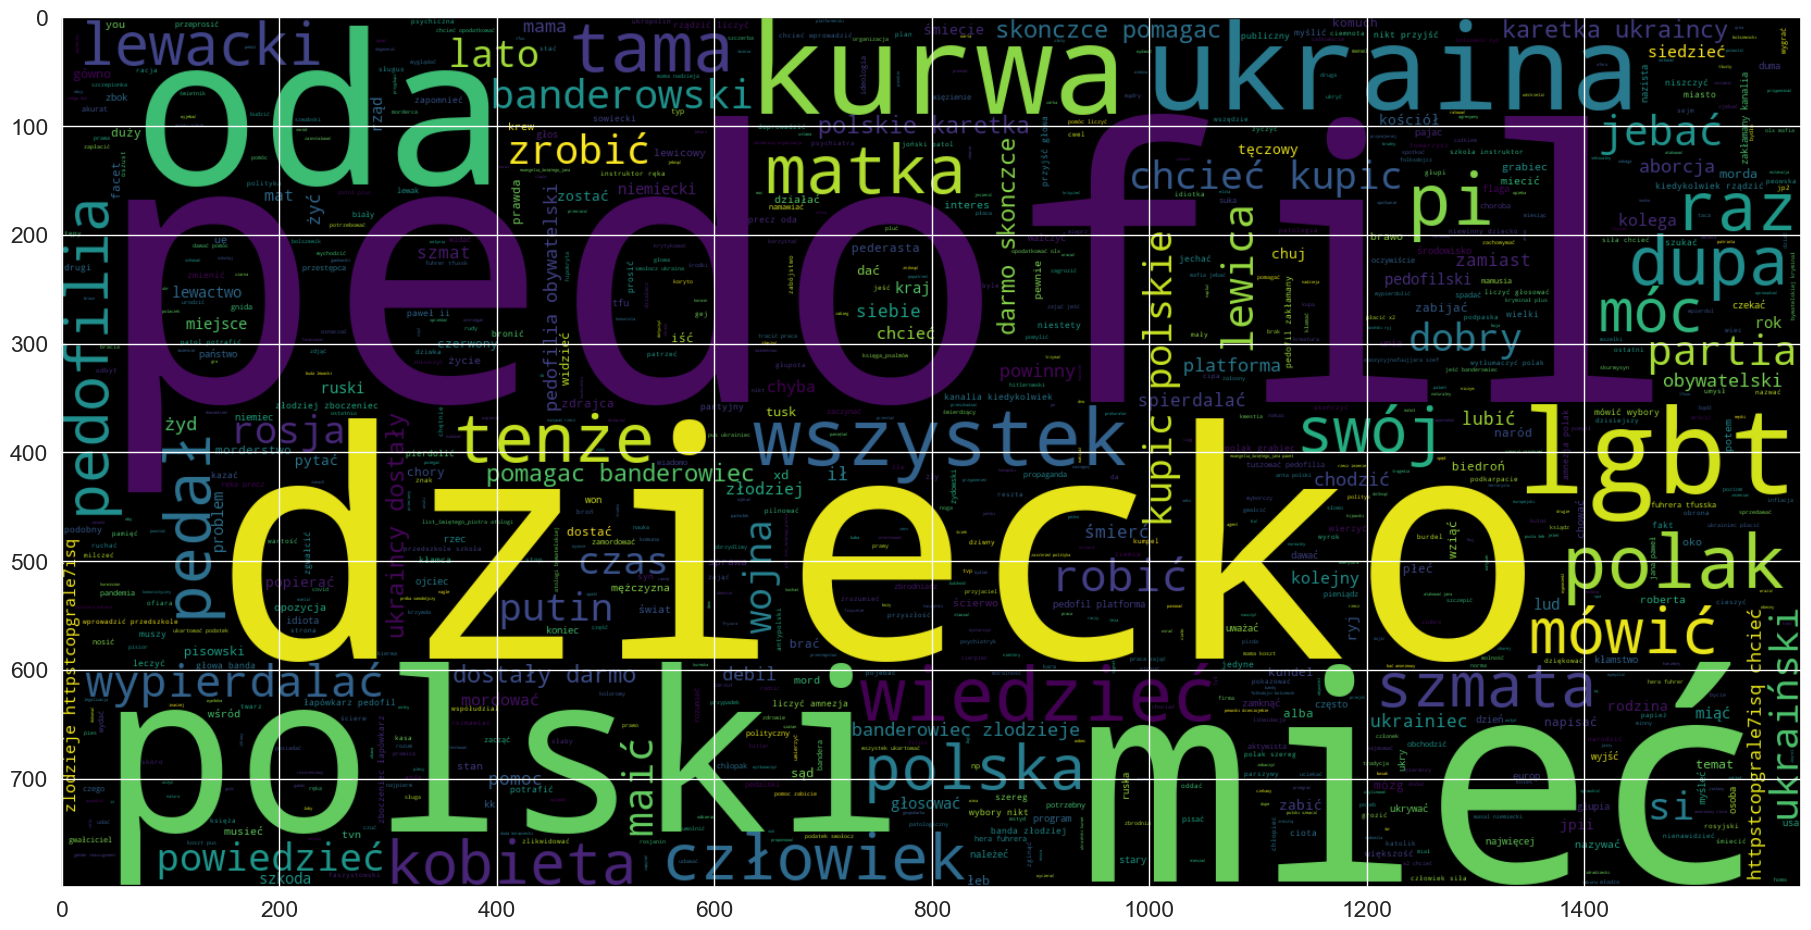

In [ ]:
plt.figure(figsize = (20,20)) 
wc1 = WordCloud(
    max_words = 1000,
    width = 1600,
    height = 800,
    stopwords = STOPWORDS
    ).generate(" ".join(df[df.label == 1].text_str))
plt.imshow(wc , interpolation = 'bilinear')

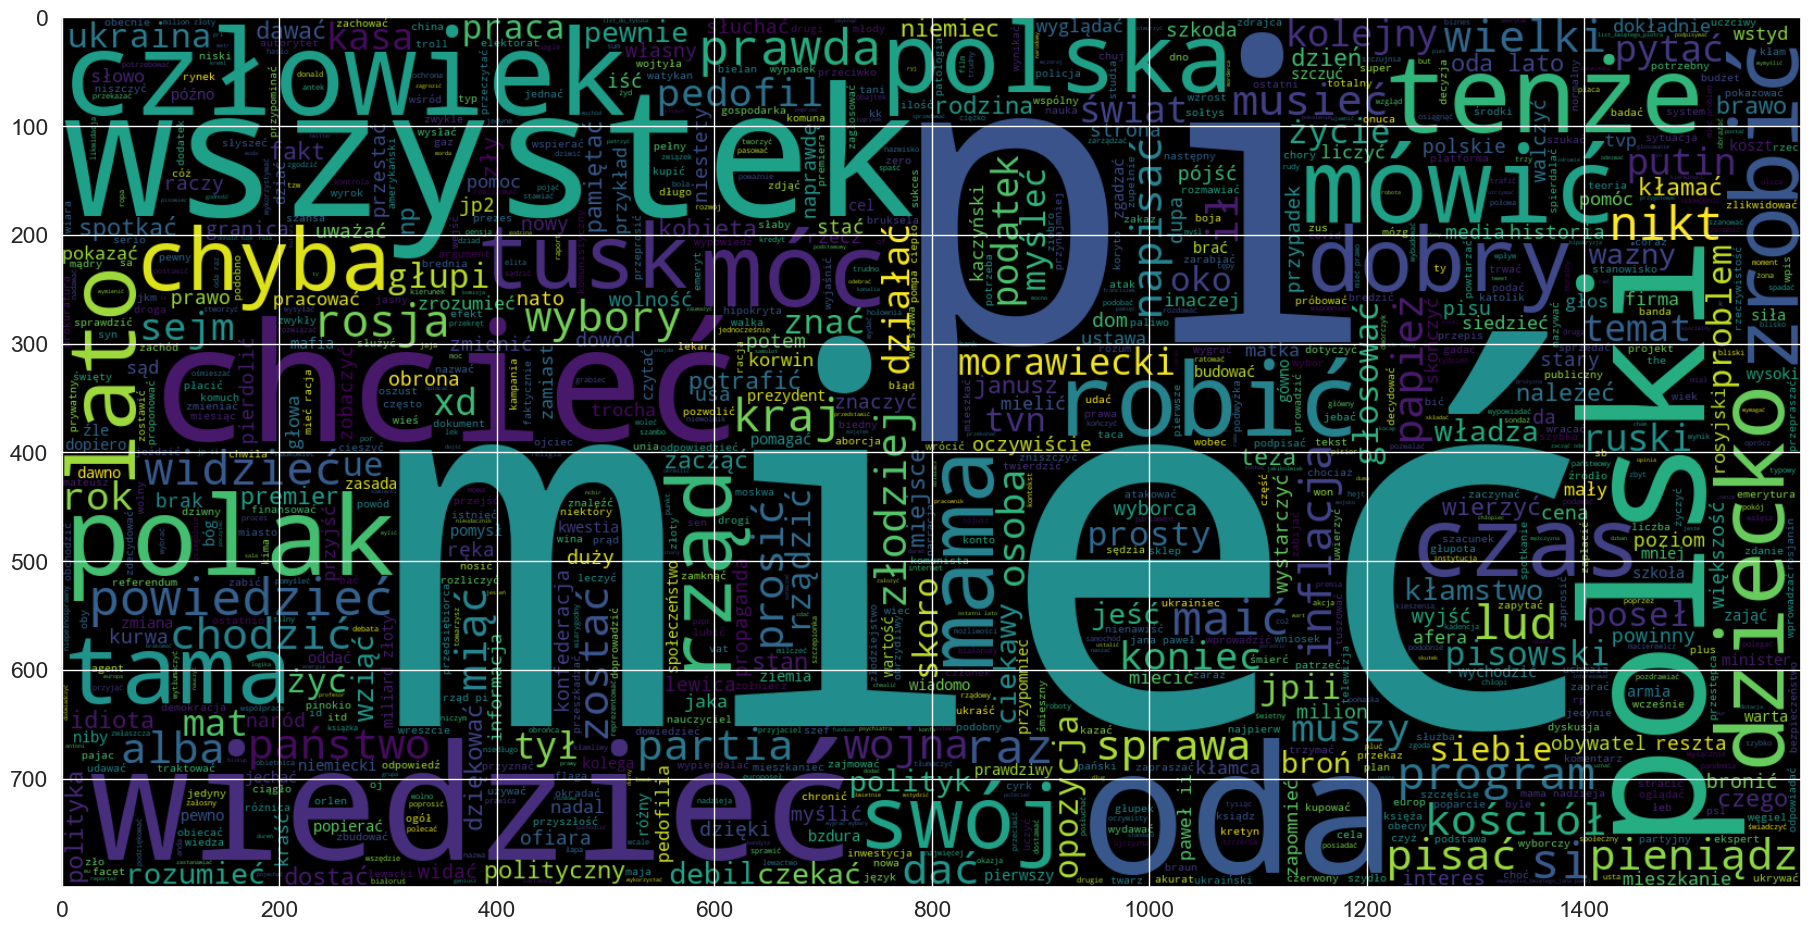

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 1000,
    width = 1600,
    height = 800,
    stopwords = STOPWORDS
    ).generate(" ".join(df[df.label == 0].text_str))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
# Setting mask for wordcloud.
mask = np.array(Image.open(r'E:\coding\pythonnew\POLHATE-project\assets\Twitterlogo.png'))
# mask[mask.sum(axis=2) == 0] = 255

In [ ]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        mask=mask,
        contour_width=0.1,
        contour_color='grey',
    ).generate(str(mostcommon))    

    def grey_color_func(word,
                        font_size,
                        position,
                        orientation,
                        random_state=None,
                        **kwargs):
        # A definition for creating grey color shades.
        return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()

In [ ]:
plot_wordcloud(df[df['target'] == 0]['tokenized'],
               'Most Common Words in Non Hate Speech Tweets',
               title_size=30)

KeyError: 'target'

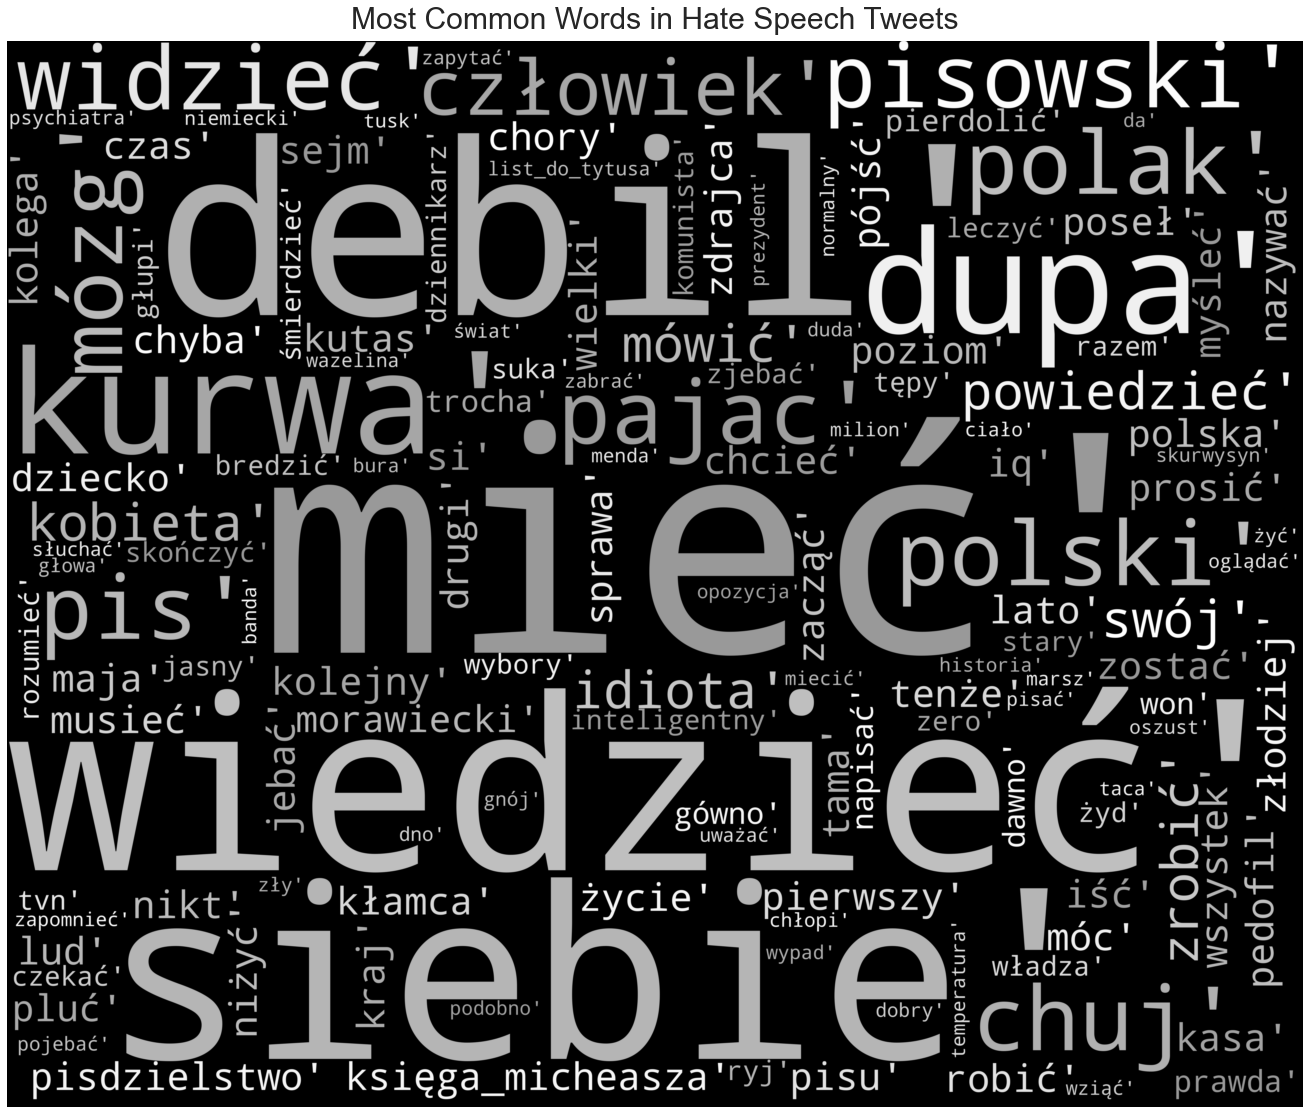

In [ ]:
plot_wordcloud(df[df['target'] == 1]['tokenized'],
               'Most Common Words in Hate Speech Tweets',
               title_size=30)

In [ ]:
def plot_named_entity_barchart(text):
    
    """A function for extracting named entities and comparing them"""
    
    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

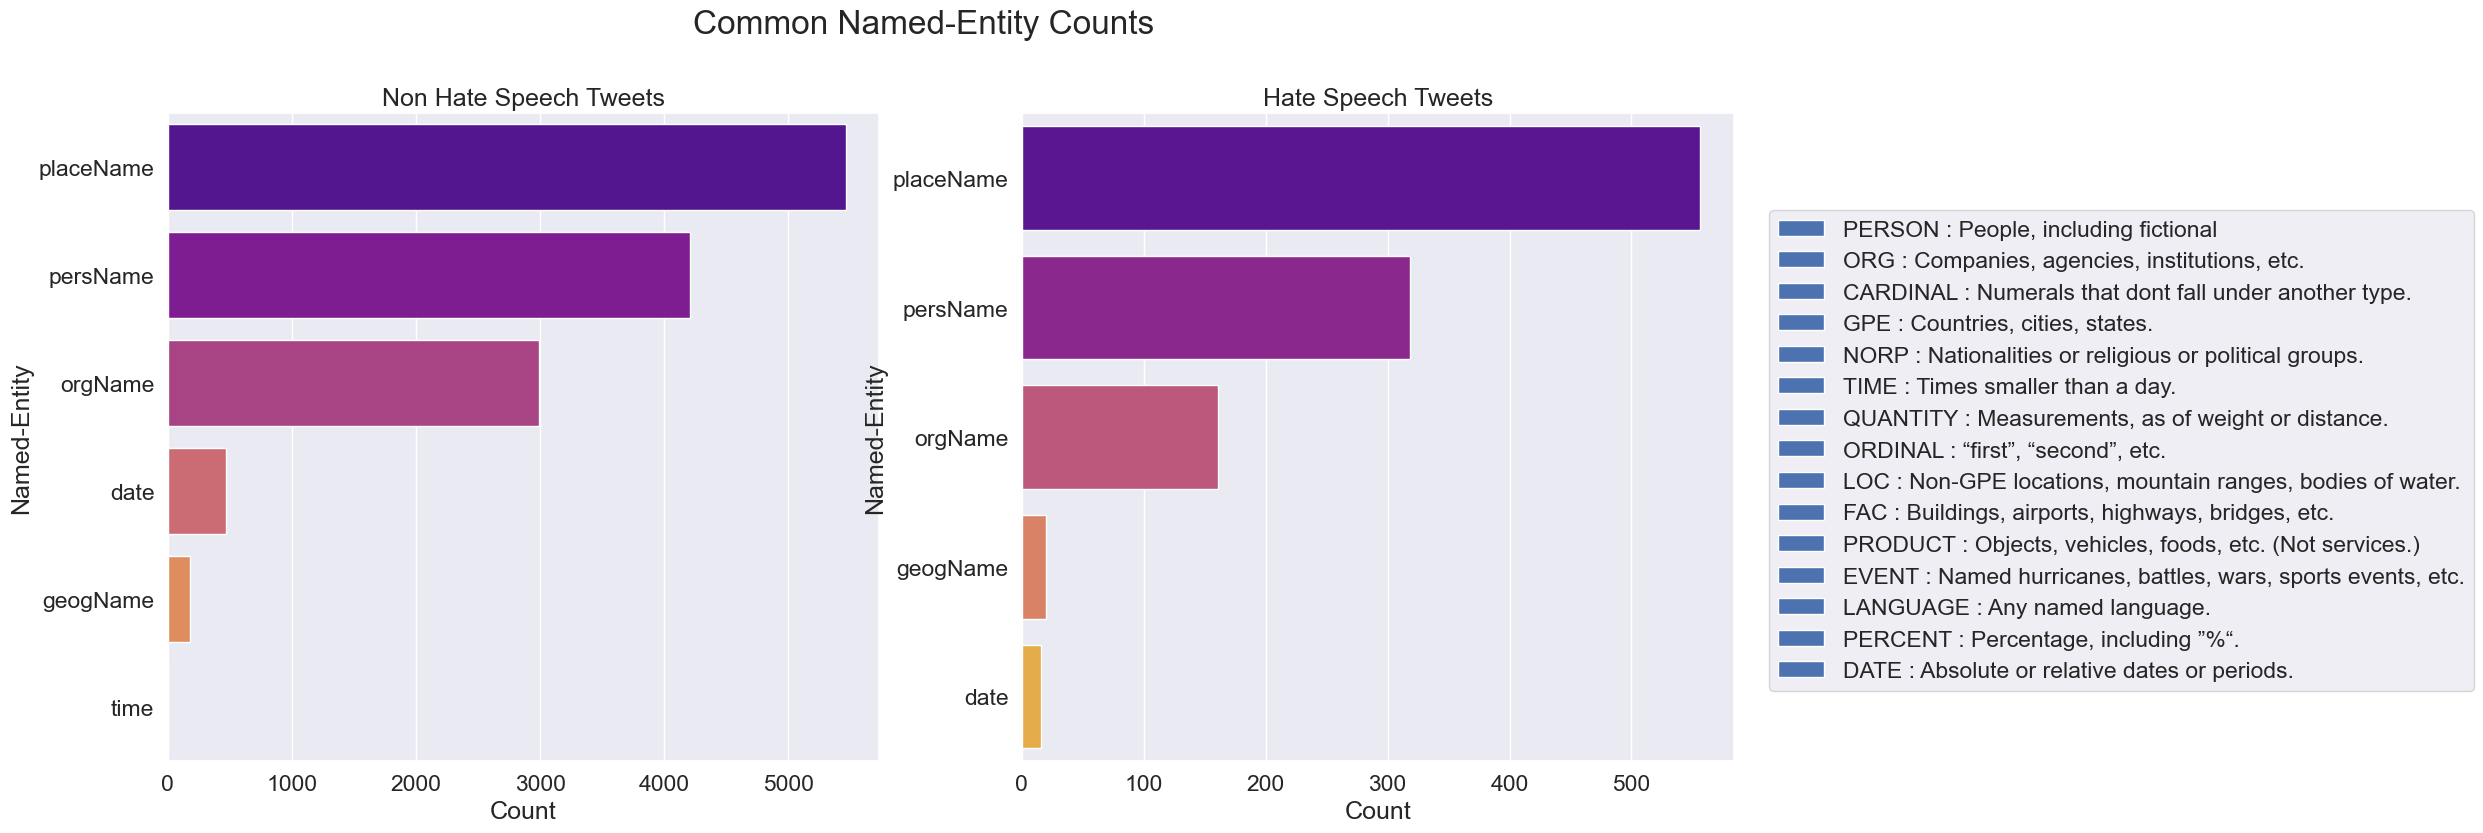

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Non Hate Speech Tweets')
axes[1].set_title('Hate Speech Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()